# Fairrets comparision

This is demo code comparing Fairrets https://github.com/aida-ugent/fairret with OxonFair using equal opportunity, and on tabular data as done in their paper.

Where possible we have followed good practices.

Fairrets doesn't use a validation set, so we merged train and val for them.

For tabular data, wide shallow networks tend to work best, so we've used these, and we use a batch size of 1000 for fairrets to try to make it more stable.

However, performance and fairness remains noticably worse than OxonFair on a network of the same architecture.

Increasing the regularisation weight to 5 or 10 increases fairness, but the classifier is strongly degraded.

If you know how to make it work better, please submit a patch.

In [1]:
# Load libraries

import oxonfair
from oxonfair import group_metrics as gm

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
import xgboost


In [2]:
#Load adult dataset, using sex as the default groups and discard sex from the raw data
train, val, test = oxonfair.dataset_loader.adult(discard_groups=True, seed=0,train_proportion=0.4,test_proportion=0.3)
#Note that Eopp is difficult because we have few positive e.g. for women and so we use more data in val, test for stability of outcome.

In [3]:
#Normalise data
std = train['data'].std()
train['data'] = train['data'] / std
val['data'] = val['data'] / std
test['data'] = test['data'] / std
# Merge train and val as fairret can't use val
fairret_data = torch.tensor(np.vstack((train['data'],val['data']))).float()
fairret_target = torch.tensor(np.hstack((train['target'],val['target']))).float()
fairret_groups = torch.tensor(np.hstack((train['groups'],val['groups']))==' Male').float()

In [4]:
#define a basic nn with 2 hidden-layers. 1 of width 100, and the second width 50.
network = nn.Sequential(nn.Linear(train['data'].shape[1],100),
                        nn.SELU(),
                        nn.Linear(100,50),
                        nn.SELU(),
                        nn.Linear(50,2))
#fairret network
network_1head = nn.Sequential(nn.Linear(train['data'].shape[1],100),
                              nn.SELU(),
                              nn.Linear(100,50),
                              nn.SELU(),
                              nn.Linear(50,1))

In [5]:
# Define a custom loss that trains the two-heads as required.
def loss(x, y, g):
    output = network(x)
    loss0 = F.binary_cross_entropy_with_logits(output[:,0], y)
    loss1 = F.mse_loss(output[:,1], g)
    return loss0+loss1

from fairret.statistic import TruePositiveRate
from fairret.loss import NormLoss

statistic = TruePositiveRate()
norm_fairret = NormLoss(statistic)

#fairret loss
def loss_1head(x,y,g,scalar=1):
    output = network_1head(x)
    y=y.reshape(-1,1)
    g=g.reshape(-1,1)
    loss0 = F.binary_cross_entropy_with_logits(output, y)
    loss1 = norm_fairret(output,g,y)
    return loss0+scalar*loss1

In [6]:
# Copy variables to tensors
target = torch.tensor(train['target']).float()
data = torch.tensor(np.asarray(train['data'])).float()
groups = torch.tensor(train['groups']==' Male').float()

optimizer = optim.Adam(network.parameters(), lr=1e-4)
optimizer_1head = optim.Adam(network_1head.parameters(), lr=1e-4)
from numpy import random

In [7]:
# Train the network
batch_size = 50

for epoch in range(100):
    #shuffle data
    perm = random.permutation(target.shape[0])
    target = target[perm]
    data = data[perm]
    groups = groups[perm]
    if epoch%10==0:
        print ('epoch is %d'%epoch)
    for step in range(target.shape[0]//batch_size): # This discards the final incomplete batch
        optimizer.zero_grad()
        l = loss(data[step*batch_size:(1+step)*batch_size],
                 target[step*batch_size:(1+step)*batch_size],
                 groups[step*batch_size:(1+step)*batch_size])
        l.backward()
        optimizer.step()

epoch is 0
epoch is 10
epoch is 20
epoch is 30
epoch is 40
epoch is 50
epoch is 60
epoch is 70
epoch is 80
epoch is 90


In [8]:
# Train the network
# Inherently any loss based fairness regulariser is unstable and needs large batches.
# This is particularly true for Equal Opportunity when positive target labels and particular groups are sparse.
# 1000 is copied from their code. It might not be large enough, but it is already causing a 6x slow down.
batch_size = 1000

for epoch in range(100):
    #shuffle data
    perm = random.permutation(fairret_target.shape[0])
    target = fairret_target[perm]
    data = fairret_data[perm]
    groups = fairret_groups[perm]
    if epoch%10==0:
        print ('epoch is %d'%epoch)
    for step in range(target.shape[0]//batch_size): # This discards the final incomplete batch
        optimizer_1head.zero_grad()
        l = loss_1head(fairret_data[step*batch_size:(1+step)*batch_size],
                 fairret_target[step*batch_size:(1+step)*batch_size],
                 fairret_groups[step*batch_size:(1+step)*batch_size],1)
        l.backward()
        optimizer_1head.step()

epoch is 0
epoch is 10
epoch is 20
epoch is 30
epoch is 40
epoch is 50
epoch is 60
epoch is 70
epoch is 80
epoch is 90


In [9]:
#convert test['data'] to tensor via numpy and then move the output back to numpy
test_output=np.asarray(network(torch.tensor(np.asarray(test['data'])).float()).detach())
test_output_1head=np.asarray(network_1head(torch.tensor(np.asarray(test['data'])).float()).detach())


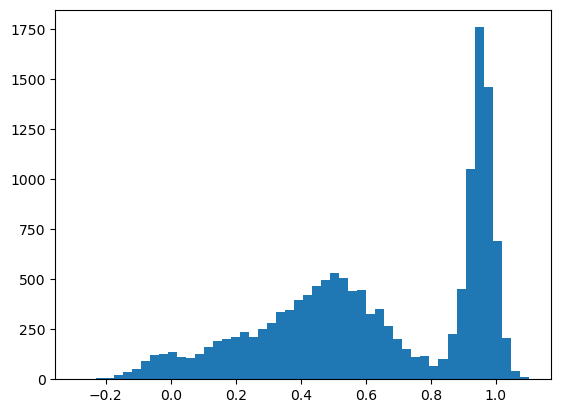

In [10]:
#Plot the outputs of the second head
from matplotlib import pyplot as plt
_=plt.hist(test_output[:,1],bins=50)

In [11]:
#Let's train a fair classifier using the two heads 
#convert val['data'] to tensor via numpy and then move the output back to numpy
val_output = np.asarray(network(torch.tensor(np.asarray(val['data'])).float()).detach())
train_output = np.asarray(network(torch.tensor(np.asarray(train['data'])).float()).detach())
test_output = np.asarray(network(torch.tensor(np.asarray(test['data'])).float()).detach())


In [12]:
fpred = oxonfair.DeepFairPredictor(val['target'],
                                   val_output,
                                   groups=val['groups'])

fpred.fit(gm.accuracy, gm.equal_opportunity, 0.01)
# Varying the grid with can improve accuracy at the cost of a longer search time.

In [13]:
test_network = oxonfair.DeepDataDict(test['target'], test_output, test['groups'])

In [14]:
# Compute
import pandas as pd
fairret_score = pd.concat((oxonfair.performance.evaluate(test['target'],test_output_1head.reshape(-1)).loc['Accuracy'],
                           oxonfair.performance.evaluate_fairness(test['target'],test_output_1head.reshape(-1),test['groups']).loc['Equal Opportunity']))
fairret_score

0    0.839555
0    0.037205
dtype: float64

In [15]:
fpred.evaluate(test_network).loc['Accuracy','updated'],fpred.evaluate_fairness(test_network).loc['Equal Opportunity','updated']

(0.8515662321708866, 0.015628036525344502)

In [16]:
# To emphasize that you shouldn't use standard neural networks on tabular data, 
# we compare with xgboost
# train a base classifier
pred = xgboost.XGBClassifier().fit(X=train['data'],y=train['target'])
# and a second classifier to infer group membership
group_pred = xgboost.XGBClassifier().fit(X=train['data'],y=train['groups'] == ' Male')
fpred2 = oxonfair.FairPredictor(pred,val, inferred_groups=group_pred)
fpred2.fit(gm.accuracy, gm.equal_opportunity, 0.01)


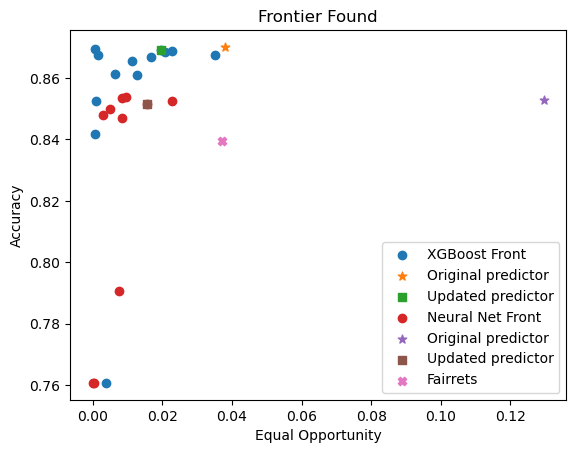

In [17]:
fpred2.plot_frontier(data=test, name_frontier='XGBoost Front')
fpred.plot_frontier(data=test_network, new_plot=False,name_frontier='Neural Net Front')
plt.scatter(y=fairret_score.iloc[0],x=fairret_score.iloc[1],label='Fairrets',marker='X')
plt.legend()


The frontier turning into this kind of noisy point cloud is expected on test data. 

For very small measures of fairness differences in sampling can lead to noticeable shifts in ordering creating these unstable orderings.

 For comparision here are the clean curves on validation data (where fairness was enforced)

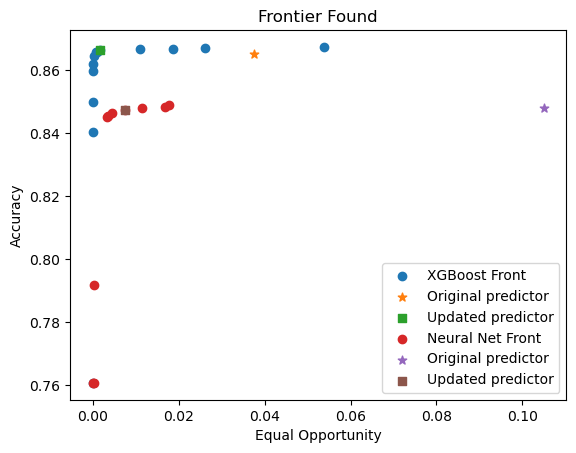

In [18]:
fpred2.plot_frontier(name_frontier='XGBoost Front')
fpred.plot_frontier(new_plot=False,name_frontier='Neural Net Front')